# Task 1

## Import Lib & Paths

In [2]:
# Import Lib & Paths
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import math
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


root = Path("/workspace") 
data_path = root / "data" / "Cars.csv"


# Load Data
df_raw = pd.read_csv(data_path)

#Explore Data (5 rows)
df_raw.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


## Cleaning Data

### Coding Condition 

In [3]:
# make sure to work on a copy of the original data
df = df_raw.copy()

In [4]:
df_raw['owner'].value_counts() # check unique values in owner column before mapping

owner
First Owner             5289
Second Owner            2105
Third Owner              555
Fourth & Above Owner     174
Test Drive Car             5
Name: count, dtype: int64

In [5]:
# feature owner (mapping to numerical values)
# i decide to using map function to replace categorical values
owner_map = {"First Owner":1,"Second Owner":2,"Third Owner":3,"Fourth & Above Owner":4,"Test Drive Car":5}
df["owner"] = df["owner"].map(owner_map)

In [6]:
# we are going to drop CNG and LPG (remove all rows with CNG and LPG fuel type)
df = df[~df["fuel"].isin(["CNG","LPG"])].reset_index(drop=True)

In [7]:
df['fuel'].value_counts() # CNG and LPG rows are removed!

fuel
Diesel    4402
Petrol    3631
Name: count, dtype: int64

In [8]:
# we found that in columns mileage have text with numbers, so we need to extract only numbers and convert to float

# Split the string on space  take the first part (the number) and then convert to float
df["mileage"] = df["mileage"].str.split().str[0].astype(float)

# Quick check
print(df["mileage"].head())
print(df["mileage"].dtype)

0    23.40
1    21.14
2    17.70
3    23.00
4    16.10
Name: mileage, dtype: float64
float64


In [9]:
# do the same for engine and max_power
# Remove the "CC" suffix and convert to float
df["engine"] = df["engine"].str.split().str[0].astype(float)

df["max_power"] = pd.to_numeric(df["max_power"].str.split().str[0], errors="coerce").astype(float)

In [ ]:
df.head() #let's check values that we already changes

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0


In [ ]:
# for the brand column, we can extract the first word from the name column 
# so i decide to create a new column brand by extracting the first word from the name column
df["brand"] = df["name"].str.split().str[0]

print(df["brand"].head())

0     Maruti
1      Skoda
2      Honda
3    Hyundai
4     Maruti
Name: brand, dtype: object


In [ ]:
# drop torque columns like the chakky said :)
df.drop("torque", axis=1, inplace=True, errors="ignore")

In [13]:
# remove rows with owner value of 5 (Test Drive Car) because price is really high and we dont want to invlove
df = df[df["owner"] != 5].reset_index(drop=True)


In [ ]:
# transfrom the selling price to log scale into y variable
#y = np.log1p(df["selling_price"])

In [ ]:
df.columns # let's see all columns we have

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats',
       'brand'],
      dtype='object')

In [ ]:
# Final Dataframe so i try to select columns which can be use by create new df_final
df_final = df[['brand','year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats']]

## Exploratory Data Analysis (EDA)

In [17]:
# check numeric & categorical features
print("Numeric columns:", df_final.select_dtypes(include="number").columns.tolist())
print("Categorical columns:", df_final.select_dtypes(exclude="number").columns.tolist())

# quick summary
display(df_final.describe(include="all").T)

Numeric columns: ['year', 'selling_price', 'km_driven', 'owner', 'mileage', 'engine', 'max_power', 'seats']
Categorical columns: ['brand', 'fuel', 'seller_type', 'transmission']


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
brand,8028,32,Maruti,2378,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,8028.0,NaN,NaN,NaN,2013.815521,4.030836,1983.0,2011.0,2015.0,2017.0,2020.0
selling_price,8028.0,NaN,NaN,NaN,640393.65421,802701.548723,29999.0,260000.0,450000.0,680000.0,10000000.0
km_driven,8028.0,NaN,NaN,NaN,69773.140259,56644.187102,1000.0,35000.0,60000.0,98000.0,2360457.0
fuel,8028,2,Diesel,4401,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller_type,8028,3,Individual,6673,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transmission,8028,2,Manual,6982,NaN,NaN,NaN,NaN,NaN,NaN,NaN
owner,8028.0,NaN,NaN,NaN,1.458022,0.715283,1.0,1.0,1.0,2.0,4.0
mileage,7814.0,NaN,NaN,NaN,19.391962,4.001972,0.0,16.78,19.3,22.32,42.0
engine,7814.0,NaN,NaN,NaN,1462.91464,504.759742,624.0,1197.0,1248.0,1582.0,3604.0


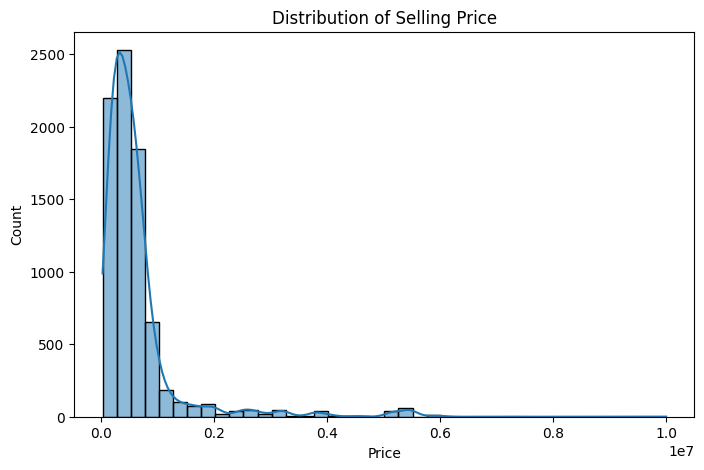

In [18]:
# i would like to see the distribution of the target variable (selling_price)
plt.figure(figsize=(8,5))
sns.histplot(df_final["selling_price"], bins=40, kde=True)
plt.title("Distribution of Selling Price")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

mostly on 100K range

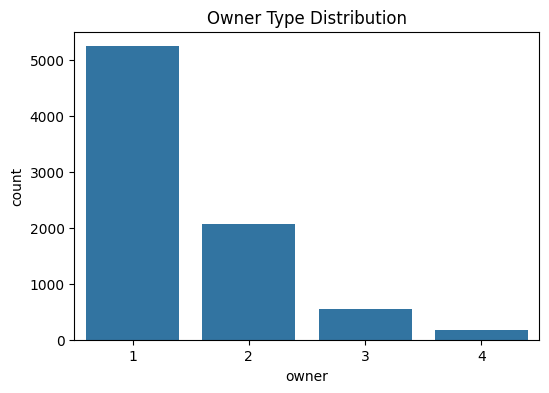

In [19]:
#checking type of owner
plt.figure(figsize=(6,4))
sns.countplot(x="owner", data=df_final)
plt.title("Owner Type Distribution")
plt.show()

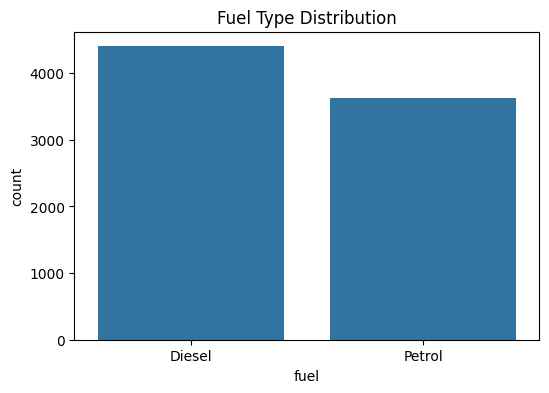

In [20]:
plt.figure(figsize=(6,4))
sns.countplot(x="fuel", data=df_final)
plt.title("Fuel Type Distribution")
plt.show()

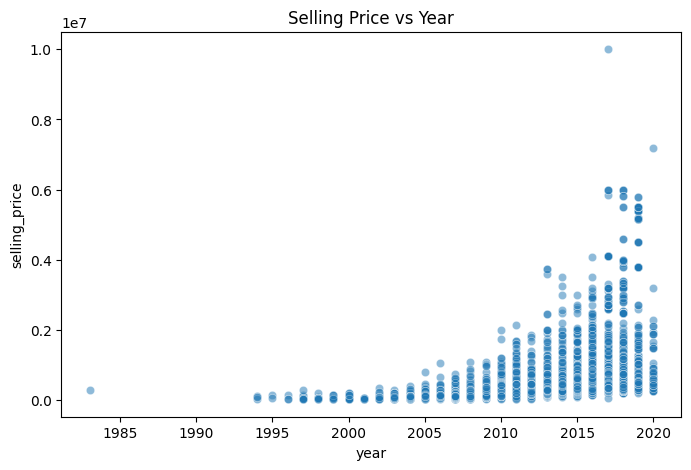

In [21]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="year", y="selling_price", data=df_final, alpha=0.5)
plt.title("Selling Price vs Year")
plt.show()

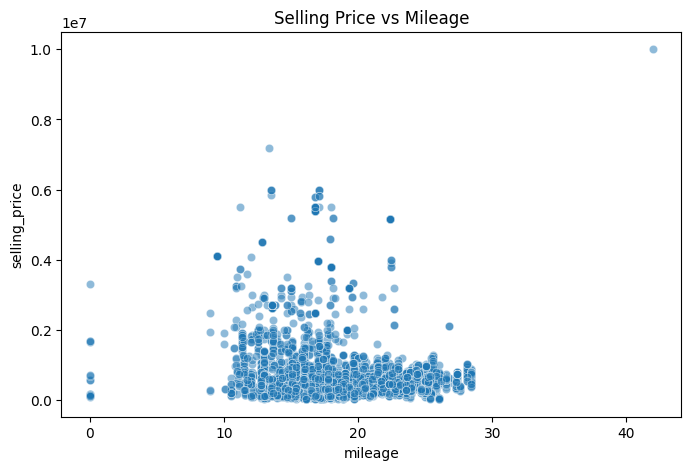

In [22]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="mileage", y="selling_price", data=df_final, alpha=0.5)
plt.title("Selling Price vs Mileage")
plt.show()

In [23]:
# let's find out that outliers in mileage column
df_final[df_final['mileage'] > 40]

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
167,Volvo,2017,10000000,30000,Petrol,Individual,Automatic,1,42.0,1969.0,400.0,4.0


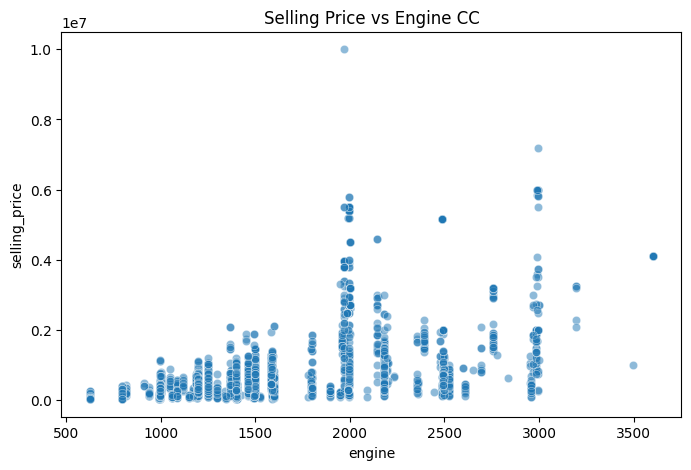

In [24]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="engine", y="selling_price", data=df_final, alpha=0.5)
plt.title("Selling Price vs Engine CC")
plt.show()

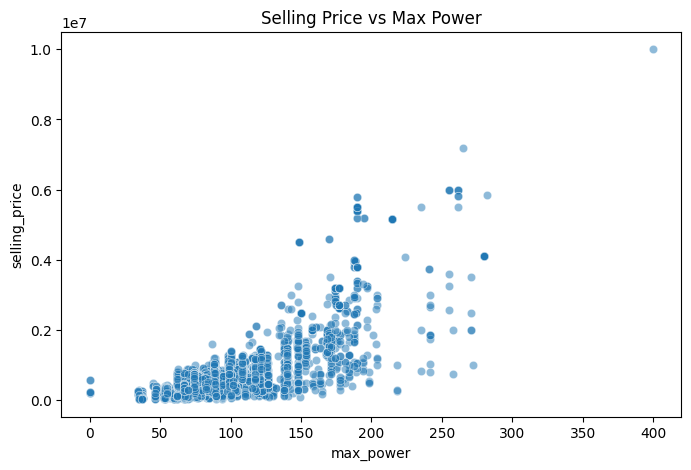

In [25]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="max_power", y="selling_price", data=df_final, alpha=0.5)
plt.title("Selling Price vs Max Power")
plt.show()

It seems that factors such as max_power, engine, and year may be interesting to investigate, so we will first check them in the correlation heatmap. Before that, let us explore the differences across the categorical columns.

<Axes: xlabel='fuel', ylabel='selling_price'>

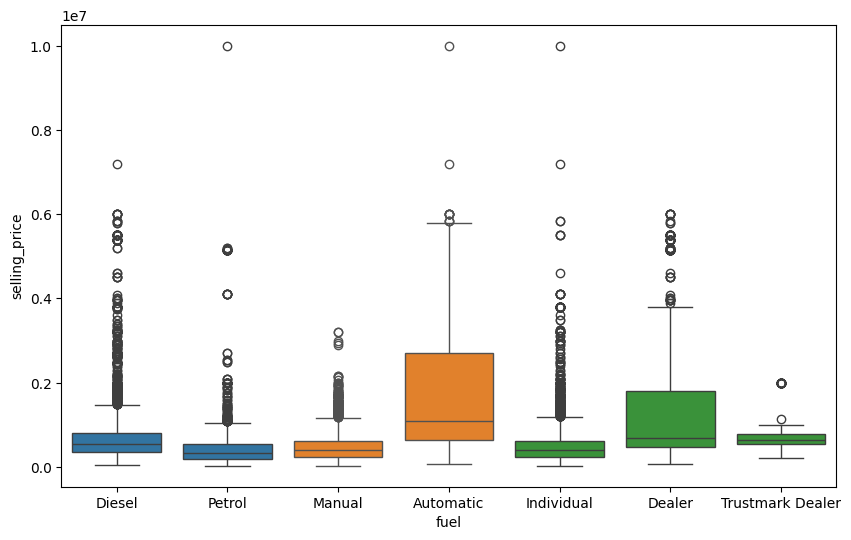

In [28]:
plt.figure(figsize=(10,6))
sns.boxplot(x="fuel", y="selling_price", data=df_final)
sns.boxplot(x="transmission", y="selling_price", data=df_final)
sns.boxplot(x="seller_type", y="selling_price", data=df_final)

We observe that for the transmission feature, cars with automatic transmission tend to have a wider price range compared to manual. A similar pattern is also seen in the seller_type feature. Therefore, I would like to examine the price range for each brand to help decide which factors to select.

<Axes: xlabel='brand', ylabel='selling_price'>

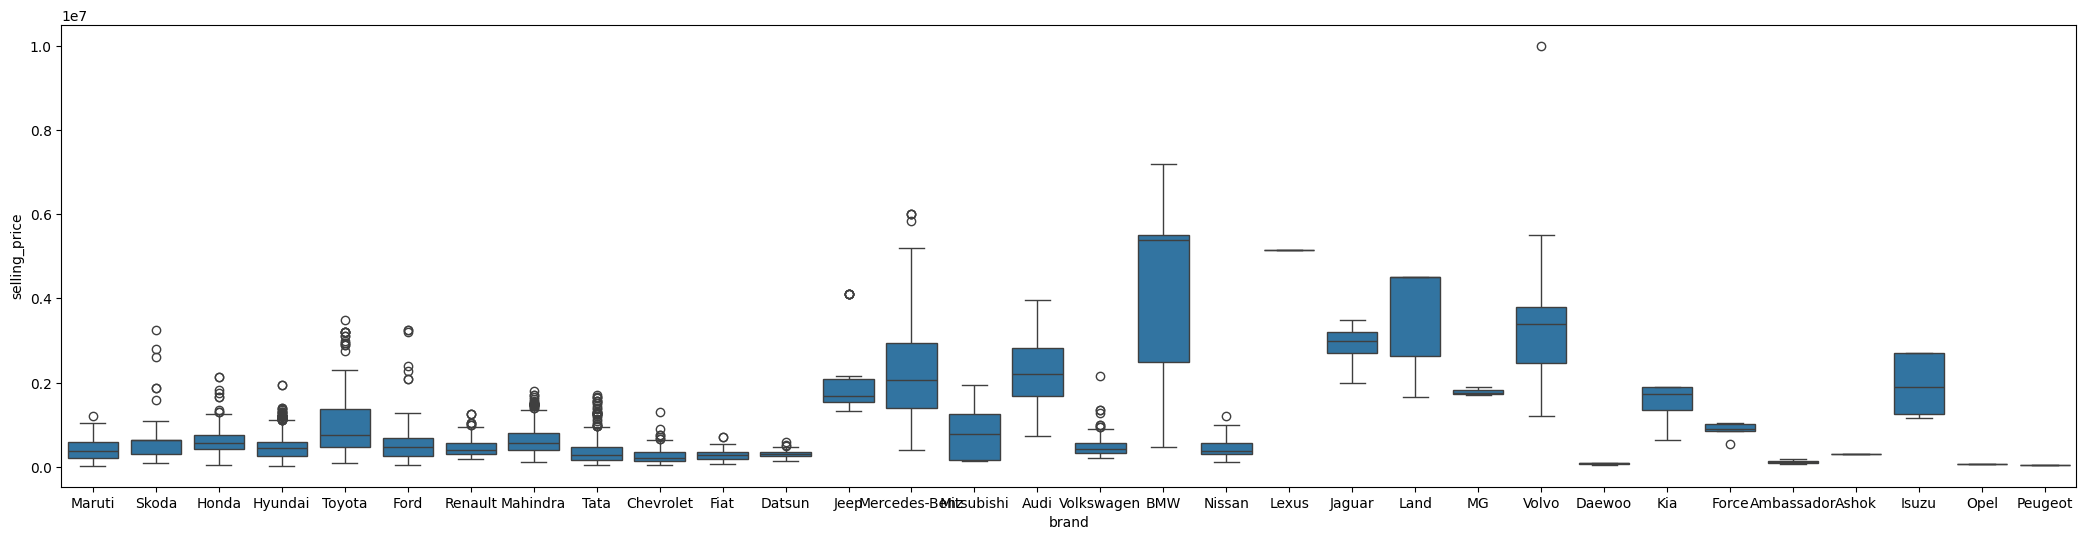

In [29]:
plt.figure(figsize=(26,6))
sns.boxplot(x="brand", y="selling_price", data=df_final)

In my opinion, brand influences price differences, so we will include it as a categorical feature.

Let's see heat map

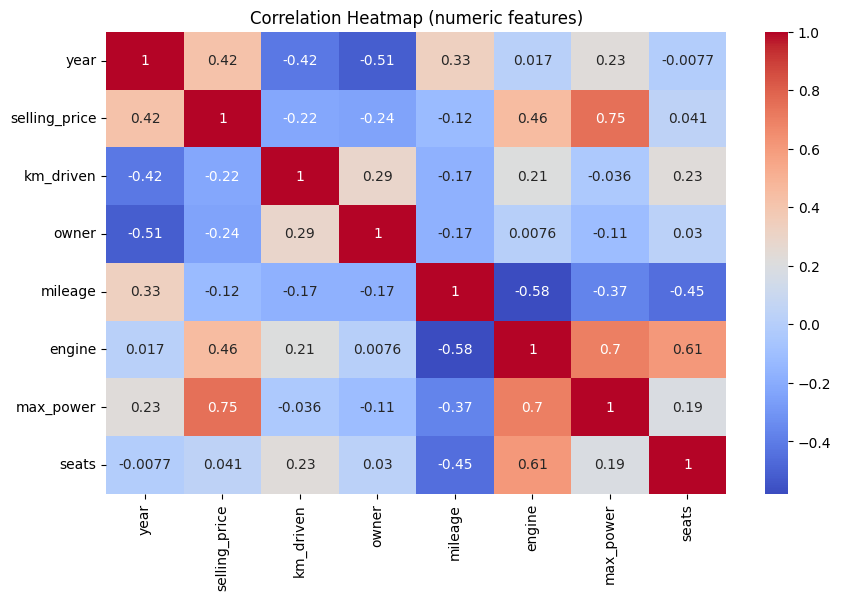

In [30]:
plt.figure(figsize=(10,6))
sns.heatmap(df_final.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (numeric features)")
plt.show()

We found that year, engine, and max_power all have a positive correlation with price, while km_driven shows a negative correlation.

## Split train & test data set

In [63]:
df_final.head() # let's see final data again

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,5.0
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,5.0
2,Honda,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,5.0
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,5.0
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,5.0


In [64]:
target = "selling_price"
X = df_final.drop(columns=[target])   # keep 'brand' (already extracted), drop raw 'name'
y = df_final[target].values

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
) # so let's split data train and test data before we preprocessing


## Preprocessing

In [35]:
# Checking for null values
X_train.isnull().sum()

brand             0
year              0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage         171
engine          171
max_power       165
seats           171
dtype: int64

we have some null values so we have to check distribution first before select tool 

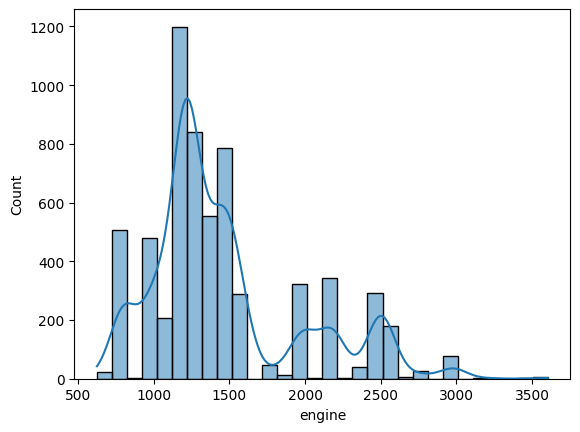

In [36]:
sns.histplot(X_train["engine"], bins=30, kde=True)
plt.show()

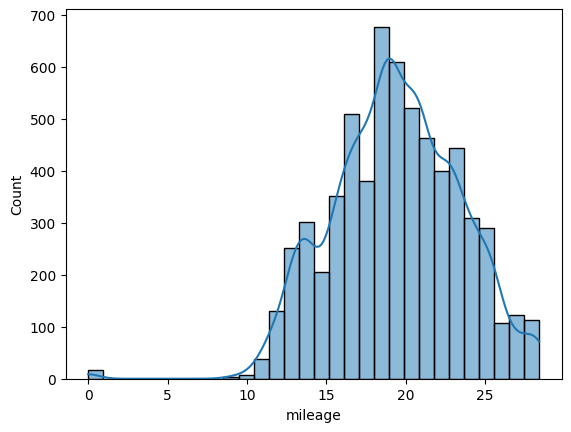

In [37]:
sns.histplot(X_train["mileage"], bins=30, kde=True)
plt.show()

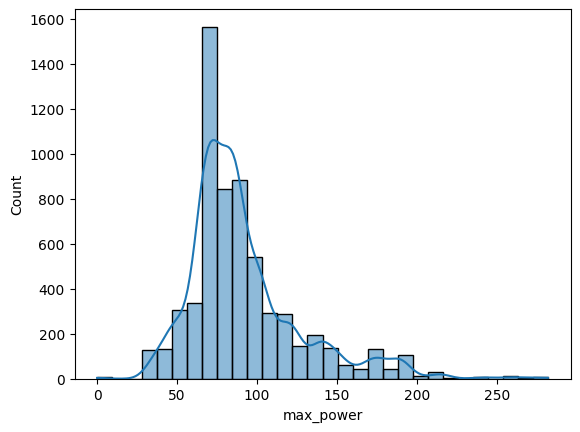

In [38]:
sns.histplot(X_train["max_power"], bins=30, kde=True)
plt.show()

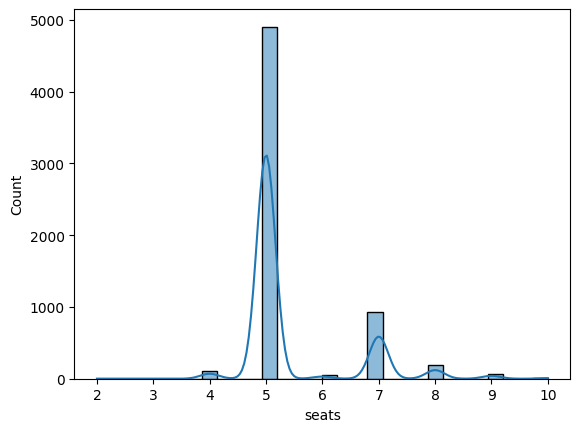

In [39]:
sns.histplot(X_train["seats"], bins=30, kde=True)
plt.show()

ngine
From the histogram, the distribution of engine is highly skewed and not symmetric.
→ Using median imputation is more robust than mean, since median is less sensitive to extreme values.

Max Power
The distribution of max_power is right-skewed (a few cars with very high power).
→ Similar to engine, we select median imputation to reduce the effect of outliers.


Seats
The distribution of seats is categorical-like, with clear peaks at 5 seats, 7 seats, and a few other values.
→ For this kind of discrete feature, mode imputation is the best choice, since it preserves the most common category.

Mileage
The distribution of mileage looks closer to normal, centered around ~18–20 kmpl.
→ Mean imputation is appropriate, because the mean is representative of the central tendency here.


## deal with null

I use a preprocessing pipeline where categorical features are imputed with mode and one-hot encoded, numerical features are imputed based on their distributions (engine/max_power → median, mileage → mean, seats → mode), while year, km_driven, and owner are passed through directly.

In [ ]:
cat_cols = ["fuel", "seller_type", "transmission", "brand"]
num_cols = [col for col in df_final.columns if col not in cat_cols + ["selling_price"]]
preproc = ColumnTransformer([

    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),


    ("num_median", Pipeline([
        ("impute", SimpleImputer(strategy="median"))
    ]), ["engine", "max_power"]),

    ("num_mean", Pipeline([
        ("impute", SimpleImputer(strategy="mean"))
    ]), ["mileage"]),


    ("num_mode", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent"))
    ]), ["seats"]),
    ("num_pass", "passthrough", ["year", "km_driven", "owner"]),
])

fit and transform the training data with the preprocessing pipeline, convert the output to dense if it’s sparse, and check that no NaN values remain after preprocessing. 

In [ ]:
Xt = preproc.fit_transform(X_train)

if hasattr(Xt, "toarray"):
    Xt = Xt.toarray()

print("NaN left after preprocessing:", np.isnan(Xt).sum())

NaN left after preprocessing: 0


### Checking Outliers

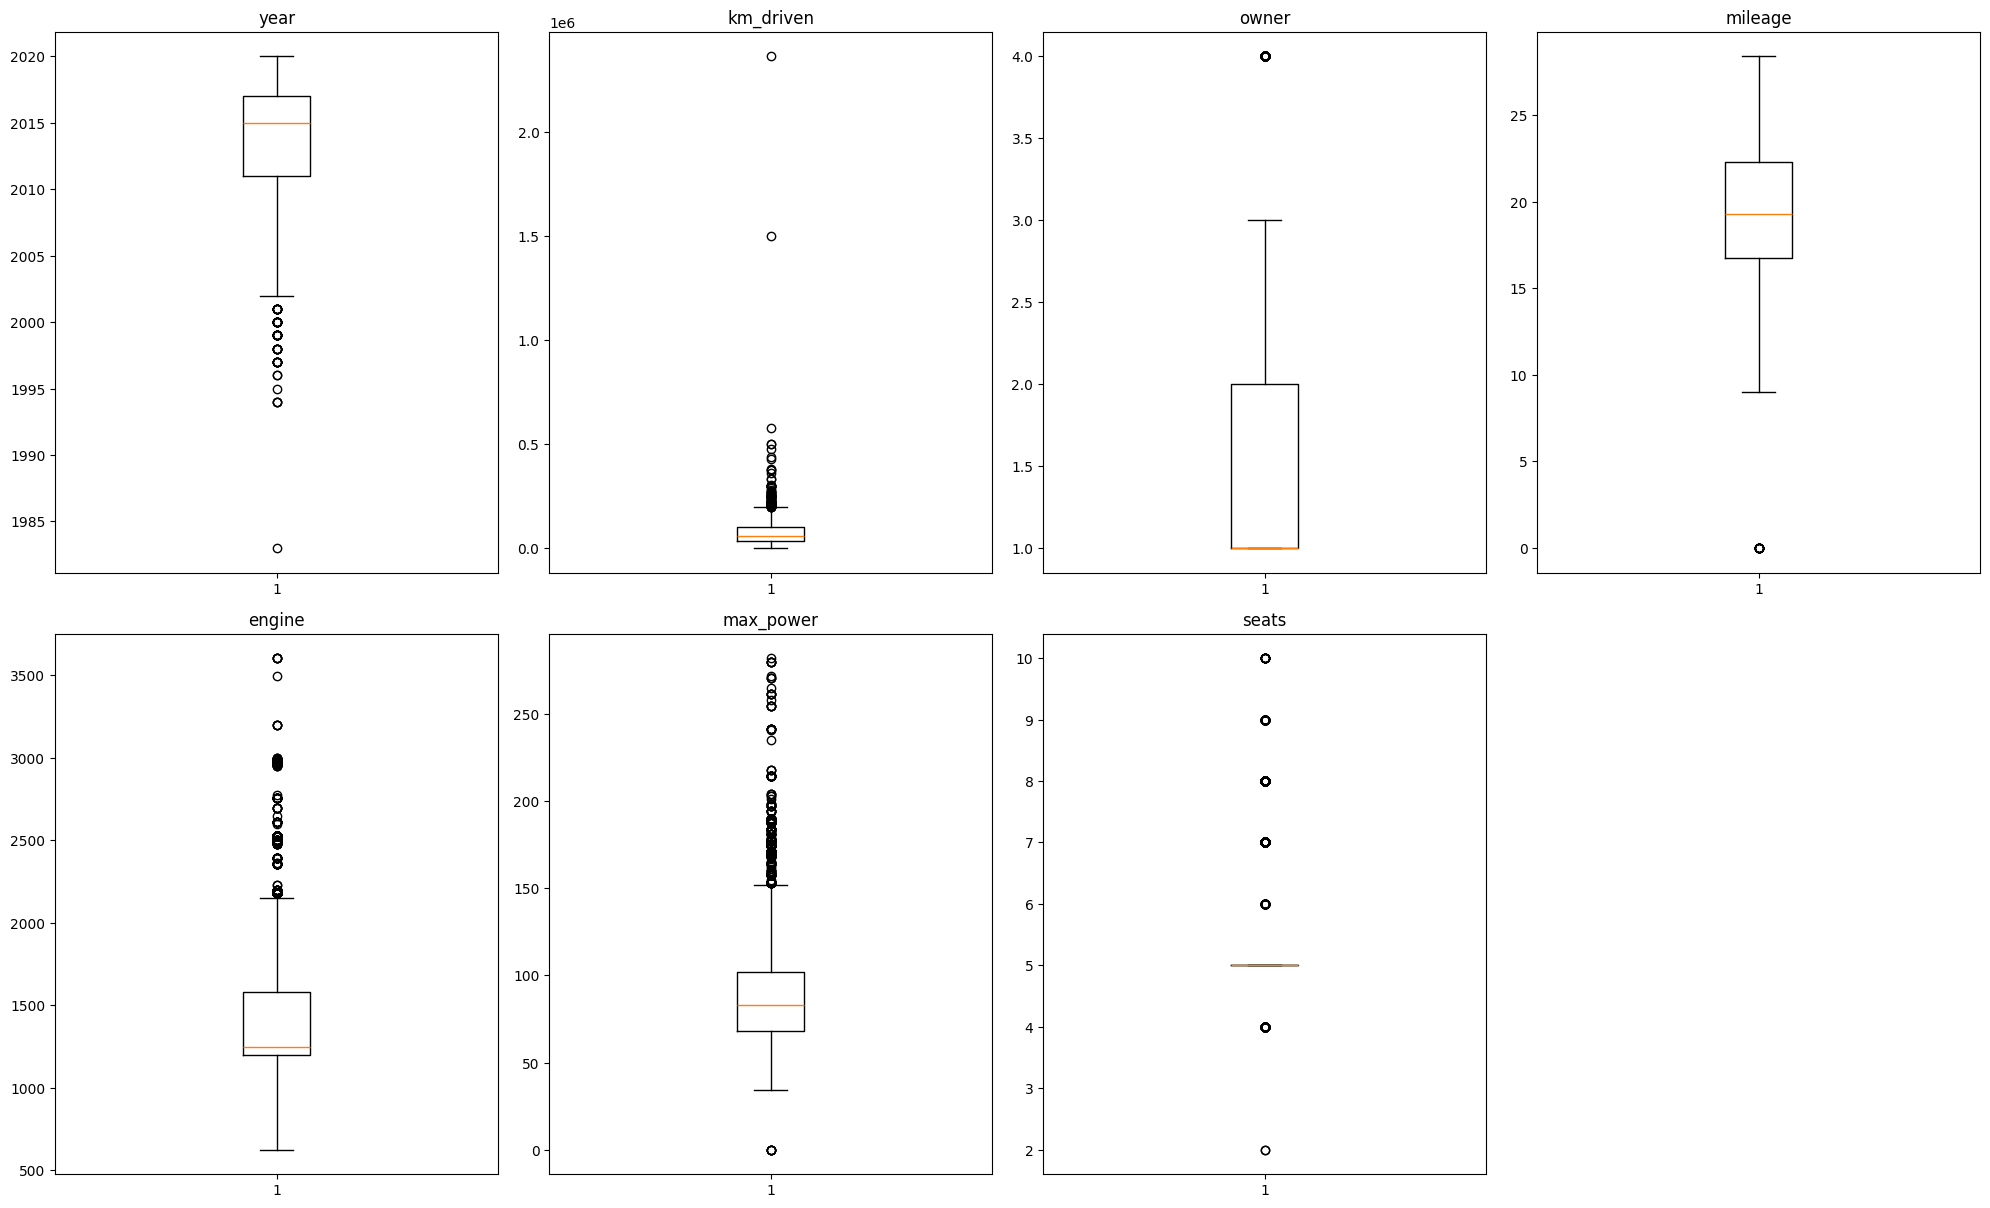

In [42]:
# to understand outlier in this data
plt.figure(figsize=(20,30))

for i, variable in enumerate(num_cols, 1):   
    plt.subplot(5, 4, i)                     
    plt.boxplot(X_train[variable].dropna())  
    plt.title(variable)

plt.tight_layout()
plt.show()

build a pipeline that applies preprocessing and a Linear Regression model, wrap it with a TransformedTargetRegressor to model the log of the target (and inverse-transform back with exp), fit it on the training data, and then generate predictions on the test set.

In [ ]:
lin_model = Pipeline([
    ("prep", preproc),      
    ("reg", LinearRegression())
])

lin_ttr = TransformedTargetRegressor(
    regressor=lin_model, func=np.log, inverse_func=np.exp
)

lin_ttr.fit(X_train, y_train)   
preds = lin_ttr.predict(X_test) 

evaluate the Linear Regression model by calculating MAE, MSE, RMSE, and R² on both the training and test sets to compare errors and assess model performance.

In [44]:
y_train_pred = lin_ttr.predict(X_train)
y_test_pred  = lin_ttr.predict(X_test)

# --- TRAIN ---
mae_train  = mean_absolute_error(y_train, y_train_pred)
mse_train  = mean_squared_error(y_train, y_train_pred)          # MSE
rmse_train = np.sqrt(mse_train)                                  # RMSE = sqrt(MSE)
r2_train   = r2_score(y_train, y_train_pred)

print("📘 Training set performance")
print(f"MAE  : {mae_train:,.0f}")
print(f"MSE  : {mse_train:,.0f}")
print(f"RMSE : {rmse_train:,.0f}")
print(f"R²    : {r2_train:.3f}")

# --- TEST ---
mae_test  = mean_absolute_error(y_test, y_test_pred)
mse_test  = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test   = r2_score(y_test, y_test_pred)

print("\n📗 Test set performance")
print(f"MAE  : {mae_test:,.0f}")
print(f"MSE  : {mse_test:,.0f}")
print(f"RMSE : {rmse_test:,.0f}")
print(f"R²    : {r2_test:.3f}")

📘 Training set performance
MAE  : 132,482
MSE  : 82,554,413,342
RMSE : 287,323
R²    : 0.865

📗 Test set performance
MAE  : 140,741
MSE  : 98,828,877,398
RMSE : 314,371
R²    : 0.872


The Linear Regression model achieves good R² (~0.87) but has large errors (MAE ~130–140k, RMSE ~280–310k)

try more complex models and compare their performance with cross-validation.

In [ ]:
def make_estimator(name, base_reg):
    steps = [("prep", preproc)]
    if name in ("SVR", "KNeighbors Regressor"):
        steps.append(("scale", StandardScaler(with_mean=False))) 
    steps.append(("reg", base_reg))
    pipe = Pipeline(steps)
    return TransformedTargetRegressor(regressor=pipe, func=np.log, inverse_func=np.exp)


models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(kernel="rbf", C=10.0, gamma="scale"),
    "KNeighbors Regressor": KNeighborsRegressor(n_neighbors=7, weights="distance"),
    "Decision-Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random-Forest Regressor": RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
}


scoring = {
    "mse": "neg_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2",
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

results = []
for name, base in models.items():
    est = make_estimator(name, base)
    cv = cross_validate(est, X, y, cv=kfold, scoring=scoring, n_jobs=-1)
    mse  = -cv["test_mse"]
    mae  = -cv["test_mae"]
    r2   = cv["test_r2"]
    rmse = np.sqrt(mse)

    results.append({
        "Model": name,
        "MAE": mae.mean(),
        "RMSE": rmse.mean(),
        "MSE": mse.mean(),
        "R²": r2.mean()
    })

cv_results = pd.DataFrame(results).sort_values("RMSE")
print(cv_results)

                     Model            MAE           RMSE           MSE  \
4  Random-Forest Regressor   66054.561035  144254.243419  2.178742e+10   
2     KNeighbors Regressor   75734.036811  180207.387132  3.359897e+10   
3  Decision-Tree Regressor   79007.285695  182044.143127  3.415589e+10   
0        Linear Regression  135870.762243  294234.625494  8.676454e+10   
1                      SVR  174318.156853  395957.596031  1.578845e+11   

         R²  
4  0.967004  
2  0.948620  
3  0.947722  
0  0.864453  
1  0.755442  


In [46]:
cv_results

,Model,MAE,RMSE,MSE,R²
4,Random-Forest Regressor,66054.561035,144254.243419,2.178742e+10,0.967004
2,KNeighbors Regressor,75734.036811,180207.387132,3.359897e+10,0.948620
3,Decision-Tree Regressor,79007.285695,182044.143127,3.415589e+10,0.947722
0,Linear Regression,135870.762243,294234.625494,8.676454e+10,0.864453
1,SVR,174318.156853,395957.596031,1.578845e+11,0.755442


Random Forest performs best (MAE ≈ 66k, RMSE ≈ 144k, R² ≈ 0.97), followed by KNN and Decision Tree. Linear Regression and SVR lag behind, showing higher errors and lower R².

next try improve model

by performed a two-stage GridSearch (coarse → fine) on Random Forest; the best model was found with tuned hyperparameters, giving the lowest CV RMSE among all tested settings.

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np

kfold3 = KFold(n_splits=3, shuffle=True, random_state=42)


def make_rf_estimator(base_rf=None):
    if base_rf is None:
        base_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    pipe = Pipeline([
        ("prep", preproc),  
        ("reg", base_rf),
    ])
    return TransformedTargetRegressor(
        regressor=pipe, func=np.log, inverse_func=np.exp
    )

rf_est = make_rf_estimator()



param_grid_coarse = {
    "regressor__reg__n_estimators": [200, 400],
    "regressor__reg__max_depth": [None, 15],
    "regressor__reg__min_samples_split": [2, 5],
    "regressor__reg__min_samples_leaf": [1, 2],
    "regressor__reg__max_features": ["sqrt", "log2"],
}
gs1 = GridSearchCV(
    estimator=rf_est,
    param_grid=param_grid_coarse,
    scoring="neg_mean_squared_error",
    cv=kfold3, n_jobs=-1, verbose=1
)
gs1.fit(X, y)
print("Coarse best:", gs1.best_params_, "CV_RMSE:", np.sqrt(-gs1.best_score_))


bp = gs1.best_params_
param_grid_fine = {
    "regressor__reg__n_estimators": [bp["regressor__reg__n_estimators"], bp["regressor__reg__n_estimators"]*2],
    "regressor__reg__max_depth": [bp["regressor__reg__max_depth"]] if bp["regressor__reg__max_depth"] is None else [bp["regressor__reg__max_depth"]-5, bp["regressor__reg__max_depth"], bp["regressor__reg__max_depth"]+5],
    "regressor__reg__min_samples_split": [max(2, bp["regressor__reg__min_samples_split"]-1), bp["regressor__reg__min_samples_split"], bp["regressor__reg__min_samples_split"]+1],
    "regressor__reg__min_samples_leaf": [bp["regressor__reg__min_samples_leaf"], bp["regressor__reg__min_samples_leaf"]+1],
    "regressor__reg__max_features": [bp["regressor__reg__max_features"]],
}
gs2 = GridSearchCV(
    estimator=rf_est,
    param_grid=param_grid_fine,
    scoring="neg_mean_squared_error",
    cv=kfold3, n_jobs=-1, verbose=1
)
gs2.fit(X, y)
best_rf = gs2.best_estimator_
print("Fine best:", gs2.best_params_, "CV_RMSE:", np.sqrt(-gs2.best_score_))

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Coarse best: {'regressor__reg__max_depth': None, 'regressor__reg__max_features': 'sqrt', 'regressor__reg__min_samples_leaf': 1, 'regressor__reg__min_samples_split': 2, 'regressor__reg__n_estimators': 400} CV_RMSE: 167623.84607674324
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fine best: {'regressor__reg__max_depth': None, 'regressor__reg__max_features': 'sqrt', 'regressor__reg__min_samples_leaf': 1, 'regressor__reg__min_samples_split': 2, 'regressor__reg__n_estimators': 400} CV_RMSE: 167623.84607674318


Best params stabilized across both stages: n_estimators=400, max_depth=None, max_features=‘sqrt’, min_samples_split=2, min_samples_leaf=1, with CV RMSE ≈ 167,624 the coarse and fine searches converged to the same optimum.

In [49]:
ytr = best_rf.predict(X_train)
yte = best_rf.predict(X_test)

print("\n▶ RandomForest (best from GridSearch on train)")
print("Train → MAE:", f"{mean_absolute_error(y_train, ytr):,.0f}",
      "RMSE:", f"{np.sqrt(mean_squared_error(y_train, ytr)):,.0f}",
      "R²:", f"{r2_score(y_train, ytr):.3f}")
print("Test  → MAE:", f"{mean_absolute_error(y_test, yte):,.0f}",
      "RMSE:", f"{np.sqrt(mean_squared_error(y_test, yte)):,.0f}",
      "R²:", f"{r2_score(y_test, yte):.3f}")


▶ RandomForest (best from GridSearch on train)
Train → MAE: 25,421 RMSE: 55,473 R²: 0.995
Test  → MAE: 28,128 RMSE: 125,940 R²: 0.980


The tuned Random Forest model achieved excellent results (Train R² = 0.995, Test R² = 0.980) with much lower errors than Linear Regression. This shows the model captures nonlinear relationships between features like year, engine, max_power, and brand. Compared to simpler models, Random Forest provides the best balance of accuracy and generalization, making it the final chosen model for deployment.

## Feature Importance

This code extracts feature importances from the trained Random Forest, combines one-hot encoded categorical features back into their original groups (fuel, seller_type, transmission, brand), and then plots their overall contribution.


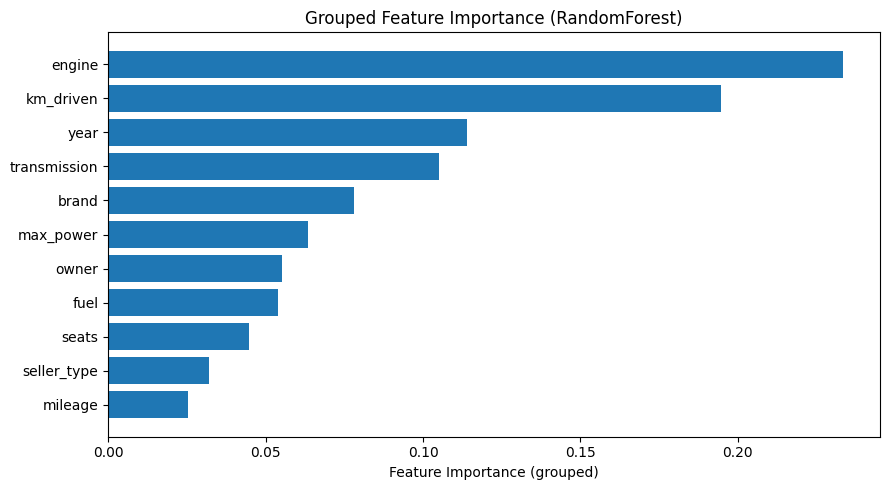

In [ ]:
rf_core = best_rf.regressor_.named_steps["reg"]


prep = best_rf.regressor_.named_steps["prep"]
ohe = prep.named_transformers_["cat"]["ohe"]


cat_input_names = ["fuel", "seller_type", "transmission", "brand"]
cat_features = ohe.get_feature_names_out(cat_input_names)


num_features = [c for c in X.columns if c not in cat_input_names]  # หรือจะระบุรายชื่อเองก็ได้


all_features = list(cat_features) + num_features

importances = rf_core.feature_importances_

imp_detail = (
    pd.DataFrame({"feature": all_features, "importance": importances})
      .sort_values("importance", ascending=False)
      .reset_index(drop=True)
)


grouped_imp = {}
for f, val in zip(all_features, importances):
    if f.startswith("fuel_"):
        grouped_imp["fuel"] = grouped_imp.get("fuel", 0) + val
    elif f.startswith("seller_type_"):
        grouped_imp["seller_type"] = grouped_imp.get("seller_type", 0) + val
    elif f.startswith("transmission_"):
        grouped_imp["transmission"] = grouped_imp.get("transmission", 0) + val
    elif f.startswith("brand_"):
        grouped_imp["brand"] = grouped_imp.get("brand", 0) + val
    else:

        grouped_imp[f] = grouped_imp.get(f, 0) + val

imp_grouped = (
    pd.DataFrame({"feature": list(grouped_imp.keys()),
                  "importance": list(grouped_imp.values())})
      .sort_values("importance", ascending=False)
      .reset_index(drop=True)
)

plt.figure(figsize=(9,5))
plt.barh(imp_grouped["feature"][::-1], imp_grouped["importance"][::-1])
plt.xlabel("Feature Importance (grouped)")
plt.title("Grouped Feature Importance (RandomForest)")
plt.tight_layout()
plt.show()


The result shows that engine, km_driven, and year are the most influential predictors of car price, while factors like mileage and seller_type have much smaller impact.

## Inference

takes the best hyperparameters found by GridSearch (gs2.best_params_), unwraps them into a clean dictionary, and rebuilds a fresh RandomForestRegressor with those exact settings.

### Remark
### •	If you want maximum precision, you can stop here and continue directly to running the Dash application.

In [ ]:
bp = gs2.best_params_
print(bp)

best_params = {
    "n_estimators":        bp["regressor__reg__n_estimators"],
    "max_depth":           bp["regressor__reg__max_depth"],
    "min_samples_split":   bp["regressor__reg__min_samples_split"],
    "min_samples_leaf":    bp["regressor__reg__min_samples_leaf"],
    "max_features":        bp["regressor__reg__max_features"],
    "n_jobs": -1,
    "random_state": 42
}


final_rf = RandomForestRegressor(**best_params)
final_pipe = Pipeline([
    ("prep", preproc),
    ("reg", final_rf),
])
final_model = TransformedTargetRegressor(
    regressor=final_pipe,
    func=np.log, inverse_func=np.exp
)


final_model.fit(X_train, y_train)


from joblib import dump
dump(final_model, "/workspace/app/model.joblib")

{'regressor__reg__max_depth': None, 'regressor__reg__max_features': 'sqrt', 'regressor__reg__min_samples_leaf': 1, 'regressor__reg__min_samples_split': 2, 'regressor__reg__n_estimators': 400}


['/workspace/app/model.joblib']

This code loads the saved model, prepares one sample from the dataset, and compares the model’s predicted price with the actual price.

In [54]:
from joblib import load
import pandas as pd

model = load("/workspace/app/model.joblib")

ALL_COLS = ["fuel","seller_type","transmission","brand",
            "year","km_driven","owner","engine","max_power","mileage","seats"]

row = df_final.loc[1]
payload = row[ALL_COLS].to_dict()

import numpy as np
for c in ["year","km_driven","owner","engine","max_power","mileage","seats"]:
    payload[c] = pd.to_numeric(payload[c], errors="coerce")

pred = model.predict(pd.DataFrame([payload], columns=ALL_COLS))[0]
print("actual :", f"{float(row['selling_price']):,.0f}")
print("predict:", f"{pred:,.0f}")

actual : 370,000
predict: 387,976


As the predicted values are close to the actual ones, we will proceed to deploy this model

### Remark
###	• Since the trained model was too large to upload to GitHub (>100 MB), I compressed it into a smaller version that can still be used for inference in the app.


In [ ]:
from pathlib import Path
from joblib import dump, load
import shutil


cwd = Path.cwd()
if (cwd / "notebooks").exists() and not (cwd / "app").exists():
    repo_root = cwd.parent
else:
    repo_root = cwd


scales_dir = repo_root / "Model Scales"   
scales_dir.mkdir(exist_ok=True, parents=True)


app_dir = repo_root / "app"
app_dir.mkdir(exist_ok=True, parents=True)
final_target = app_dir / "model.joblib"


opts = [0, ('gzip', 3), ('gzip', 9), ('xz', 3), ('xz', 9)]
sizes = []

print("Saving compressed models to:", scales_dir.resolve())
for comp in opts:
    out = scales_dir / f"model_comp_{str(comp).replace(' ', '')}.joblib"
    dump(final_model, out.as_posix(), compress=comp, protocol=5)
    sz_mb = out.stat().st_size / 1024 / 1024
    sizes.append((out, sz_mb, comp))
    print(f" - {out.name:28s} → {sz_mb:.2f} MB  (compress={comp})")

if not sizes:
    raise FileNotFoundError("No .joblib files were created in 'Model Scales'.")

best_path, best_size_mb, best_comp = min(sizes, key=lambda x: x[1])
print(f"\n✅ Smallest model: {best_path.name} → {best_size_mb:.2f} MB")


shutil.copy2(best_path, final_target)
print(f"🚀 Copied to: {final_target.resolve()}")


try:
    _ = load(final_target.as_posix())
    print("🟢 Loaded model.joblib successfully. Dash can use this file.")
except Exception as e:
    print("🔴 Failed to load model.joblib after copy:", e)

Saving compressed models to: /workspace/notebooks/Model Scales
 - model_comp_0.joblib          → 187.92 MB  (compress=0)
 - model_comp_('gzip',3).joblib → 43.79 MB  (compress=('gzip', 3))
 - model_comp_('gzip',9).joblib → 39.85 MB  (compress=('gzip', 9))
 - model_comp_('xz',3).joblib   → 29.28 MB  (compress=('xz', 3))
 - model_comp_('xz',9).joblib   → 24.25 MB  (compress=('xz', 9))

✅ Smallest model: model_comp_('xz',9).joblib → 24.25 MB
🚀 Copied to: /workspace/notebooks/app/model.joblib
🟢 Loaded model.joblib successfully. Dash can use this file.


# Task 2

## Modeling and Evaluation — Summary

## •	   From the results, features like engine size, max_power, and year are the most important for predicting car price. Newer cars with stronger engines and higher power usually sell for more, while high km_driven lowers the value, showing a negative correlation. Mileage, transmission, seller_type, and brand also contribute, but they are less influential compared to the main technical features. 
## The grouped feature importance analysis confirmed that brand and engine-related features dominated. When comparing algorithms, Random Forest Regressor clearly performed best, achieving MAE ≈ 28K, RMSE ≈ 126K, and R² ≈ 0.98 on the test set after GridSearch tuning (best parameters like n_estimators=400, max_features="sqrt"). 
## Linear Regression underfit with R² ≈ 0.86, SVR was the weakest, and Decision Tree/KNN gave moderate results. Because Random Forest produced predictions closest to the actual prices, it was chosen as the final model for deployment in Task 3. Since the trained model file was larger than GitHub’s 100MB limit, I compressed it before uploading, ensuring it still works properly for inference in the web app.


# Task 3

## Deployment

### Github :  https://github.com/gossbu666/car-prices-prediction-st126055
